In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Module 10a: Apache Iceberg Lakehouse on Google Cloud

## 1. About Apache Iceberg tables on BigQuery

BigQuery offers two ways to work with Apache Iceberg tables:

1. [BigQuery Tables for Apache Iceberg](https://docs.cloud.google.com/biglake/docs/biglake-iceberg-tables-in-bigquery#create-iceberg-tables)<br>
2. [BigLake metastore with the Iceberg REST catalog](https://cloud.google.com/bigquery/docs/blms-rest-catalog)<br>

In this module, we will cover creating and load [BigQuery Tables for Apache Iceberg](https://cloud.google.com/bigquery/docs/iceberg-tables) and perform CRUD operations on the data with BigQuery GoogleSQL.

These tables are read-only for Apache Spark and without access to the metastore that is part of the "managed" BigQuery Iceberg tables. We will simply read these tables from Apache Spark on Dataproc Serverless in a Colab notebook.


## 2. Objectives

You will learn to:

* Prepare raw Parquet data
* Create managed BigQuery Iceberg tables into a raw zone in the lakehouse
* Load parquet into managed BigQuery Iceberg tables in the raw zone of the lakehouse
* Transform data in managed BigQuery Iceberg tables and persist to the curated zone of the lakehouse
* Read data in the curated zone from Apache Spark on Dataproc Serverless

## 3. Set up



In [ ]:
PROJECT_ID_LIST=!gcloud config list --format "value(core.project)" 2>/dev/null
PROJECT_ID=PROJECT_ID_LIST[0]
PROJECT_NBR_LIST=!gcloud projects describe $PROJECT_ID --format="value(projectNumber)"
PROJECT_NBR=PROJECT_NBR_LIST[0]
BQ_SOURCE_DS="rscw_oltp_stg_ds"
LOCATION="us-central1"


print(f"PROJECT_ID={PROJECT_ID}")
print(f"PROJECT_NBR={PROJECT_NBR}")
print(f"BQ_SOURCE_DS={BQ_SOURCE_DS}")

PROJECT_ID=data-insights-quickstart
PROJECT_NBR=606804615020
BQ_SOURCE_DS=rscw_oltp_stg_ds


### 3.1. Create a BigQuery Dataset

Running the following query creates a [BigQuery dataset](https://cloud.google.com/bigquery/docs/datasets-intro) called **`rscw_iceberg_raw_ds`** and **`rscw_iceberg_curated_ds`** to house any tables that are part of this tutorial and representing the raw and curated zones of the lakehouse.

In [ ]:
%%bigquery --project {PROJECT_ID} --location {LOCATION}

CREATE SCHEMA `rscw_iceberg_raw_ds` OPTIONS (location = 'us-central1');
CREATE SCHEMA `rscw_iceberg_curated_ds` OPTIONS (location = 'us-central1');
CREATE SCHEMA `rscw_iceberg_consumption_ds` OPTIONS (location = 'us-central1');
CREATE SCHEMA `rscw_iceberg_distribution_ds` OPTIONS (location = 'us-central1');

Query is running:   0%|          |

""


### 3.2. Set Colab display options

Colab includes the `google.colab.data_table` package that can be used to display large pandas dataframes as an interactive data table. It can be enabled with:

In [ ]:
%load_ext google.colab.data_table

### 3.3. Bucket for Parquet data

In [ ]:
PARQUET_STG_BUCKET = f"rscw-lh-stg-{PROJECT_NBR}/lakehouse-stage"
print(f"PARQUET_STG_BUCKET={PARQUET_STG_BUCKET}")


PARQUET_STG_BUCKET=rscw-lh-stg-606804615020/lakehouse-stage
ICEBERG_LAKEHOUSE_BUCKET=rscw-lh-stg-606804615020/lakehouse-managed


### 3.4. BQ remote connection

You will need to create a [Cloud resource connection](https://cloud.google.com/bigquery/docs/create-cloud-resource-connection). However we already created one and will reuse the same - `rscw_cloud_resource_connection_usc`

### 3.5. IAM permissions for the connection service account

The connection service account needs to be able to write to GCS, so we will give the service account storage admin role. Note: for your enterprise workloads, do follow principle of least privilege.

In [ ]:
SERVICE_ACCT = !bq show --format=prettyjson --connection us-central1.rscw_cloud_resource_connection_usc | grep "serviceAccountId" | cut -d '"' -f 4
SERVICE_ACCT_EMAIL = SERVICE_ACCT[-1]
print(SERVICE_ACCT_EMAIL)

bqcx-606804615020-e7x5@gcp-sa-bigquery-condel.iam.gserviceaccount.com


In [ ]:
import time

!gcloud projects add-iam-policy-binding --format=none $PROJECT_ID --member=serviceAccount:$SERVICE_ACCT_EMAIL --role='roles/storage.admin'

# wait 60 seconds, give IAM updates time to propagate, otherwise, following cells will fail
time.sleep(60)



Updated IAM policy for project [data-insights-quickstart].


## 4. Create parquet files for the tutorial

Lets create Parquet files off of the a few of the tables in `rscw_oltp_stg_ds` and persist to a staging bucket

In [ ]:
!echo $PROJECT_ID
!bq extract --destination_format PARQUET "$PROJECT_ID:rscw_oltp_stg_ds.customer_master" gs://{PARQUET_STG_BUCKET}/customer_master.parquet
!bq extract --destination_format PARQUET "$PROJECT_ID:rscw_oltp_stg_ds.product_master" gs://{PARQUET_STG_BUCKET}/product_master.parquet
!bq extract --destination_format PARQUET "$PROJECT_ID:rscw_oltp_stg_ds.pos_transaction_items" gs://{PARQUET_STG_BUCKET}/pos_transaction_items.parquet
!bq extract --destination_format PARQUET "$PROJECT_ID:rscw_oltp_stg_ds.pos_transactions" gs://{PARQUET_STG_BUCKET}/pos_transactions.parquet


data-insights-quickstart
Waiting on bqjob_r38644c3cc4f43bf2_0000019b0e530176_1 ... (2s) Current status: DONE   


## 5. Create & load managed BigQuery Iceberg tables in the `raw zone` of the `lakehouse`





### 5.1. Create tables

**Note:** Replace project number in the cell below with yours

In [ ]:
print(f"PROJECT_NBR={PROJECT_NBR}")

PROJECT_NBR=606804615020


In [ ]:
%%bigquery --project {PROJECT_ID} --location {LOCATION}

--Replace the project number below with your project number
DROP TABLE IF EXISTS `rscw_iceberg_raw_ds.customer_master`;
CREATE TABLE `rscw_iceberg_raw_ds.customer_master`
( customer_id STRING,
first_nm STRING,
last_nm STRING,
email STRING,
address STRING,
city STRING,
state_cd STRING,
zip_cd STRING,
country_cd STRING,
phone_nbr STRING)
WITH CONNECTION `projects/606804615020/locations/us-central1/connections/rscw_cloud_resource_connection_usc`
OPTIONS (
 file_format = 'PARQUET',
 table_format = 'ICEBERG',
 storage_uri = 'gs://rscw-lh-stg-606804615020/lakehouse-managed-raw/customer_master'
);

DROP TABLE IF EXISTS `rscw_iceberg_raw_ds.product_master`;
CREATE TABLE `rscw_iceberg_raw_ds.product_master`
(
  product_id STRING,
  product_nm STRING,
  category_id STRING,
  category_nm STRING,
  height_cm INT64,
  length_cm INT64,
  width_cm INT64,
  weight_g INT64,
  price_dollar FLOAT64,
  safety_qty FLOAT64)
WITH CONNECTION `projects/606804615020/locations/us-central1/connections/rscw_cloud_resource_connection_usc`
OPTIONS (
 file_format = 'PARQUET',
 table_format = 'ICEBERG',
 storage_uri = 'gs://rscw-lh-stg-606804615020/lakehouse-managed-raw/product_master'
);

DROP TABLE IF EXISTS `rscw_iceberg_raw_ds.pos_transactions`;
CREATE TABLE `rscw_iceberg_raw_ds.pos_transactions`
(
  transaction_id STRING,
  location_id STRING,
  customer_id STRING,
  transaction_status STRING,
  transaction_dt TIMESTAMP,
  payment_type STRING,
  payment_total_dollar FLOAT64)
WITH CONNECTION `projects/606804615020/locations/us-central1/connections/rscw_cloud_resource_connection_usc`
OPTIONS (
 file_format = 'PARQUET',
 table_format = 'ICEBERG',
 storage_uri = 'gs://rscw-lh-stg-606804615020/lakehouse-managed-raw/pos_transactions'
);

DROP TABLE IF EXISTS `rscw_iceberg_raw_ds.pos_transaction_items`;
CREATE TABLE `rscw_iceberg_raw_ds.pos_transaction_items`
(
  transaction_id STRING,
  transaction_item_id INT64,
  product_id STRING,
  supplier_id STRING,
  quantity INT64,
  price FLOAT64,
  line_item_total FLOAT64)
WITH CONNECTION `projects/606804615020/locations/us-central1/connections/rscw_cloud_resource_connection_usc`
OPTIONS (
 file_format = 'PARQUET',
 table_format = 'ICEBERG',
 storage_uri = 'gs://rscw-lh-stg-606804615020/lakehouse-managed-raw/pos_transaction_items'
);



Query is running:   0%|          |

""


### 5.2. Load data into the Iceberg tables

In [ ]:
print(f"PROJECT_NBR={PROJECT_NBR}")

PROJECT_NBR=606804615020


In [ ]:
%%bigquery --project {PROJECT_ID} --location {LOCATION}

--Replace project number 606804615020 in below with your project number

LOAD DATA INTO rscw_iceberg_raw_ds.customer_master
FROM FILES (
 format = 'parquet',
 uris = ['gs://rscw-lh-stg-606804615020/lakehouse-stage/customer_master.parquet']);

LOAD DATA INTO rscw_iceberg_raw_ds.product_master
FROM FILES (
 format = 'parquet',
 uris = ['gs://rscw-lh-stg-606804615020/lakehouse-stage/product_master.parquet']);

LOAD DATA INTO rscw_iceberg_raw_ds.pos_transactions
FROM FILES (
 format = 'parquet',
 uris = ['gs://rscw-lh-stg-606804615020/lakehouse-stage/pos_transactions.parquet']);

LOAD DATA INTO rscw_iceberg_raw_ds.pos_transaction_items
FROM FILES (
 format = 'parquet',
 uris = ['gs://rscw-lh-stg-606804615020/lakehouse-stage/pos_transaction_items.parquet']);

Executing query with job ID: 0159fb8e-5dfe-4509-9465-c1364afb9e53
Query executing: 0.15s


ERROR:
 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/data-insights-quickstart/queries/0159fb8e-5dfe-4509-9465-c1364afb9e53?maxResults=0&location=us-central1&prettyPrint=false: Invalid value: Error while reading data, error message: Failed to expand table rscw_iceberg_raw_ds.pos_transaction_items_df0b024b-a18e-449e-beb0-29e0f31900e2_source with file pattern gs://rscw-lh-stg-606804615020/lakehouse-stage/pos_transaction_items.parquet: matched no files. File: gs://rscw-lh-stg-606804615020/lakehouse-stage/pos_transaction_items.parquet at [18:1]

Location: us-central1
Job ID: 0159fb8e-5dfe-4509-9465-c1364afb9e53



### 5.3. Review the lakehouse directory in GCS for customer_master

In [ ]:
!gsutil ls -al gs://rscw-lh-stg-606804615020/lakehouse-managed-raw/customer_master

                                 gs://rscw-lh-stg-606804615020/lakehouse-managed-raw/customer_master/data/
                                 gs://rscw-lh-stg-606804615020/lakehouse-managed-raw/customer_master/metadata/


In [ ]:
!gsutil ls -al gs://rscw-lh-stg-606804615020/lakehouse-managed-raw/customer_master/data

   8151447  2025-12-11T16:49:44Z  gs://rscw-lh-stg-606804615020/lakehouse-managed-raw/customer_master/data/8687cea0-0430-4abe-b3e3-93934a5698d7-c29e6414ddc498e3-f-00000-of-00001.parquet#1765471784793301  metageneration=1
TOTAL: 1 objects, 8151447 bytes (7.77 MiB)


In [ ]:
!gsutil ls -al gs://rscw-lh-stg-606804615020/lakehouse-managed-raw/customer_master/metadata

       124  2025-12-11T16:47:52Z  gs://rscw-lh-stg-606804615020/lakehouse-managed-raw/customer_master/metadata/v0.metadata.json#1765471672321651  metageneration=1
TOTAL: 1 objects, 124 bytes (124 B)


### 5.4. Query the table with BigQuery SQL

In [ ]:
%%bigquery
select * from rscw_iceberg_raw_ds.customer_master limit 5

Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,first_nm,last_nm,email,address,city,state_cd,zip_cd,country_cd,phone_nbr
0,0b15496cbc114f48fa133a72bb4ab7b1,Aaron,Coleman,aaron.coleman@sullivan-hudson.com,815 Melissa Mills Apt. 968,Chicago,IL,60095,USA,(859) 906-6039
1,af19987afaab941ddba949ef09e2b393,Abigail,Miller,abigail.miller@douglas-jones.net,7536 Coleman Forge,Chicago,IL,60095,USA,(071) 304-3881
2,49d3b17d6ed2aeeb41c2b07e3bf81d6b,Adam,Barnett,adam.barnett@cox.com,48299 Johnson Hill,Chicago,IL,60095,USA,(203) 152-6624
3,c234ad158462f9be1addcd58a1db44d2,Alex,Burgess,alex.burgess@griffin.biz,52949 Amanda Shoals,Chicago,IL,60095,USA,(403) 226-7868
4,f5b315f45952adb68dbd409ac3261f60,Alex,Rodriguez,alex.rodriguez@patel-gibson.com,2646 Lopez Trace Suite 992,Chicago,IL,60095,USA,(541) 570-8031


## 6. Curate data in the `raw zone` and into the `curated zone`

The curated zone is where you would persist cleansed data from the raw zone.

### 6.1. Curate data

In [ ]:
%%bigquery --project {PROJECT_ID} --location {LOCATION}

CREATE OR REPLACE TABLE `rscw_iceberg_curated_ds.customer_master`
WITH CONNECTION `projects/606804615020/locations/us-central1/connections/rscw_cloud_resource_connection_usc`
OPTIONS (
    storage_uri = 'gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/customer_master',
    table_format = 'ICEBERG',
    file_format = 'PARQUET'
) AS
SELECT DISTINCT * FROM `rscw_iceberg_raw_ds.customer_master`;

CREATE OR REPLACE TABLE `rscw_iceberg_curated_ds.product_master`
WITH CONNECTION `projects/606804615020/locations/us-central1/connections/rscw_cloud_resource_connection_usc`
OPTIONS (
    storage_uri = 'gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/product_master',
    table_format = 'ICEBERG',
    file_format = 'PARQUET'
) AS
SELECT DISTINCT * FROM `rscw_iceberg_raw_ds.product_master`;

CREATE OR REPLACE TABLE `rscw_iceberg_curated_ds.pos_transactions`
WITH CONNECTION `projects/606804615020/locations/us-central1/connections/rscw_cloud_resource_connection_usc`
OPTIONS (
    storage_uri = 'gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/pos_transactions',
    table_format = 'ICEBERG',
    file_format = 'PARQUET'
) AS
SELECT DISTINCT * FROM `rscw_iceberg_raw_ds.pos_transactions`
WHERE
customer_id IN (SELECT DISTINCT customer_id from `rscw_iceberg_curated_ds.customer_master`) ;

CREATE OR REPLACE TABLE `rscw_iceberg_curated_ds.pos_transaction_items`
WITH CONNECTION `projects/606804615020/locations/us-central1/connections/rscw_cloud_resource_connection_usc`
OPTIONS (
    storage_uri = 'gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/pos_transaction_items',
    table_format = 'ICEBERG',
    file_format = 'PARQUET'
) AS
SELECT DISTINCT * FROM `rscw_iceberg_raw_ds.pos_transaction_items`
WHERE
product_id IN (SELECT DISTINCT product_id from `rscw_iceberg_curated_ds.product_master`);




Query is running:   0%|          |

""


In [ ]:
%%bigquery --project {PROJECT_ID} --location {LOCATION}

--SELECT * FROM `rscw_iceberg_curated_ds.customer_master` LIMIT 1
--SELECT * FROM `rscw_iceberg_curated_ds.product_master` LIMIT 1
--SELECT * FROM `rscw_iceberg_curated_ds.pos_transactions` LIMIT 1
--SELECT * FROM `rscw_iceberg_curated_ds.pos_transaction_items` LIMIT 1

### 6.2. Run CRUD on the Iceberg data in GCS

BigQuery managed Iceberg tables allow updates with GoogleSQL and the data and metadata updates are managed seamlessly. Queries will always return the freshest version of data post an update.

Lets update a record, and look at what the GCS layout looks like for the Iceberg table before and after the update

In [ ]:
%%bigquery

select * from rscw_iceberg_curated_ds.customer_master where customer_id='0b15496cbc114f48fa133a72bb4ab7b1'

Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,first_nm,last_nm,email,address,city,state_cd,zip_cd,country_cd,phone_nbr
0,0b15496cbc114f48fa133a72bb4ab7b1,Aaron,Coleman,aaron.coleman@sullivan-hudson.com,815 Melissa Mills Apt. 968,Chicago,IL,60095,USA,(859) 906-6039


Look at GCS before the update

In [ ]:
!gsutil ls -al gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/customer_master/metadata

In [ ]:
!gsutil ls -al gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/customer_master/metadata

Run the update

In [ ]:
%%bigquery

update rscw_iceberg_curated_ds.customer_master
set first_nm='Aron'
where customer_id='0b15496cbc114f48fa133a72bb4ab7b1'

Query is running:   0%|          |

""


In [ ]:
%%bigquery

select * from rscw_iceberg_curated_ds.customer_master where customer_id='0b15496cbc114f48fa133a72bb4ab7b1'

Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,first_nm,last_nm,email,address,city,state_cd,zip_cd,country_cd,phone_nbr
0,0b15496cbc114f48fa133a72bb4ab7b1,Aron,Coleman,aaron.coleman@sullivan-hudson.com,815 Melissa Mills Apt. 968,Chicago,IL,60095,USA,(859) 906-6039


Lets look at GCS and what's changed there with the data update

In [ ]:
!gsutil ls -al gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/customer_master/data

   8251718  2025-12-11T17:10:40Z  gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/customer_master/data/758f4cd9-e062-4d35-af31-3b798789f12e-c2f1faf14cf87dba-f-00000-of-00001.parquet#1765473040690606  metageneration=1
   8254403  2025-12-11T17:12:05Z  gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/customer_master/data/ab8ebe46-2a7b-46e5-8e9e-eea1ce2e4ed8-2221f179ae4194be-f-00000-of-00001.parquet#1765473125328003  metageneration=1
   8288718  2025-12-11T17:17:02Z  gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/customer_master/data/b36817d6-8aa4-4192-8558-a3f07a19b4d7-ce01ca2ca728c56b-f-00000-of-00001.parquet#1765473422581672  metageneration=1
   8250701  2025-12-11T17:07:56Z  gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/customer_master/data/e6e8f4e3-f4df-4a48-94af-19dbf2f38246-ad4ed16742501787-f-00000-of-00001.parquet#1765472876264114  metageneration=1
TOTAL: 4 objects, 33045540 bytes (31.51 MiB)


In [ ]:
!gsutil ls -al gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/customer_master/metadata

       128  2025-12-11T17:07:56Z  gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/customer_master/metadata/v0.metadata.json#1765472876696199  metageneration=1
TOTAL: 1 objects, 128 bytes (128 B)


In [ ]:
!gsutil cat gs://rscw-lh-stg-606804615020/lakehouse-managed-curated/customer_master/metadata/v0.metadata.json

{"properties":{"bigquery-table-id":"data-insights-quickstart.rscw_iceberg_curated_ds.customer_master"},"current-snapshot-id":-1}

A new parquet file got generated that captures the update from a cursory look. A comprehensive learning experience of Apache Iceberg as a format and the product features is available at- [` https://github.com/GoogleCloudPlatform/open-data-lakehouse-demo/tree/main`](https://github.com/GoogleCloudPlatform/open-data-lakehouse-demo/tree/main)

--

## 7. Querying BigQuery Managed Iceberg Tables from Spark

These tables are readonly for Apache Spark. Iceberg is a self-descriptive table format, and when you query BigQuery Iceberg tables via Spark, it does not have access to the BigQuery metastore, and simply relies on the Iceberg metadata that is persisted in GCS along with the data and delta logs.

### 7.1. Create a spark session

In [69]:
from google.cloud.dataproc_spark_connect import DataprocSparkSession
from google.cloud.dataproc_v1 import Session

session = Session()

session.runtime_config.version = "3.0"

# You can optionally configure Spark properties as well. See https://cloud.google.com/dataproc-serverless/docs/concepts/properties.
session.runtime_config.properties = {
  'spark.dynamicAllocation.enabled': 'false'
}

spark = (
    DataprocSparkSession.builder
      .appName("RSCW-Iceberg-SparkSession")
      .dataprocSessionConfig(session)
      .getOrCreate()
)

sc-20251211-172330-9qcen1 Dataproc Session is not active, stopping and creating a new one


████████████████████████████████████████████▎                                   

### 10.3. Query the metastore

In [ ]:
spark.sql("SHOW DATABASES").show(truncate=False)

|           0/0 Tasks

|           0/0 Tasks

+----------------------------+
|namespace                   |
+----------------------------+
|bq_forecasting              |
|rscw_dwh_ds                 |
|rscw_dwh_metadata_ds        |
|rscw_forecasting_ds         |
|rscw_iceberg_consumption_ds |
|rscw_iceberg_curated_ds     |
|rscw_iceberg_distribution_ds|
|rscw_iceberg_ds             |
|rscw_iceberg_raw_ds         |
|rscw_lh_ds                  |
|rscw_metadata_ds            |
|rscw_ml_ds                  |
|rscw_multimodal_ai_stg_ds   |
|rscw_oltp_metadata_ds       |
|rscw_oltp_stg_ds            |
|rscw_ops_ds                 |
|rscw_rpt_ds                 |
+----------------------------+



View tables in the Iceberg dataset from Spark SQL



In [ ]:
spark.sql("SHOW TABLES IN rscw_iceberg_raw_ds").show(truncate=False)

|           0/0 Tasks

|           0/0 Tasks

+----------------------------------------------+---------------------+-----------+
|namespace                                     |tableName            |isTemporary|
+----------------------------------------------+---------------------+-----------+
|`data-insights-quickstart`.rscw_iceberg_raw_ds|customer_master      |false      |
|`data-insights-quickstart`.rscw_iceberg_raw_ds|pos_transaction_items|false      |
|`data-insights-quickstart`.rscw_iceberg_raw_ds|pos_transactions     |false      |
|`data-insights-quickstart`.rscw_iceberg_raw_ds|product_master       |false      |
+----------------------------------------------+---------------------+-----------+



In [ ]:
spark.sql("SHOW TABLES IN rscw_iceberg_curated_ds").show(truncate=False)

|           0/0 Tasks

|           0/0 Tasks

+--------------------------------------------------+---------------------+-----------+
|namespace                                         |tableName            |isTemporary|
+--------------------------------------------------+---------------------+-----------+
|`data-insights-quickstart`.rscw_iceberg_curated_ds|customer_master      |false      |
|`data-insights-quickstart`.rscw_iceberg_curated_ds|pos_transaction_items|false      |
|`data-insights-quickstart`.rscw_iceberg_curated_ds|pos_transactions     |false      |
|`data-insights-quickstart`.rscw_iceberg_curated_ds|product_master       |false      |
+--------------------------------------------------+---------------------+-----------+



### 10.4. Query a table

In [ ]:
spark.sql("SELECT * FROM rscw_iceberg_curated_ds.customer_master LIMIT 2").show()

|           0/0 Tasks

  0%|           0/1 Tasks

+--------------------+--------+-------+--------------------+--------------------+----------+--------+------+----------+--------------+
|         customer_id|first_nm|last_nm|               email|             address|      city|state_cd|zip_cd|country_cd|     phone_nbr|
+--------------------+--------+-------+--------------------+--------------------+----------+--------+------+----------+--------------+
|b041cec79db612cc3...|    Paul| Holder|paul.holder@murph...| 94435 Melissa Falls|   Chicago|      IL| 60095|       USA|(162) 494-5872|
|c1858678c3bdfe0f9...|   Tyler|    Cox|tyler.cox@armstro...|664 Carter Summit...|Schaumburg|      IL| 60194|       USA|(339) 527-1339|
+--------------------+--------+-------+--------------------+--------------------+----------+--------+------+----------+--------------+



In [ ]:
spark.sql("SELECT * FROM rscw_iceberg_curated_ds.customer_master where customer_id='0b15496cbc114f48fa133a72bb4ab7b1'").show(truncate=False)

|           0/0 Tasks

  0%|           0/1 Tasks

+--------------------------------+--------+-------+---------------------------------+--------------------------+-------+--------+------+----------+--------------+
|customer_id                     |first_nm|last_nm|email                            |address                   |city   |state_cd|zip_cd|country_cd|phone_nbr     |
+--------------------------------+--------+-------+---------------------------------+--------------------------+-------+--------+------+----------+--------------+
|0b15496cbc114f48fa133a72bb4ab7b1|Aron    |Coleman|aaron.coleman@sullivan-hudson.com|815 Melissa Mills Apt. 968|Chicago|IL      |60095 |USA       |(859) 906-6039|
+--------------------------------+--------+-------+---------------------------------+--------------------------+-------+--------+------+----------+--------------+



Note how we got the freshest data from Spark. This was made possible by the Iceberg metadata pointing to the freshest record to Spark - all under the hood. This table however cannot be updated via Apache Spark, at the time of authoring this lab module.

### 10.5. Visualize some customer data

  0%|           0/1 Tasks

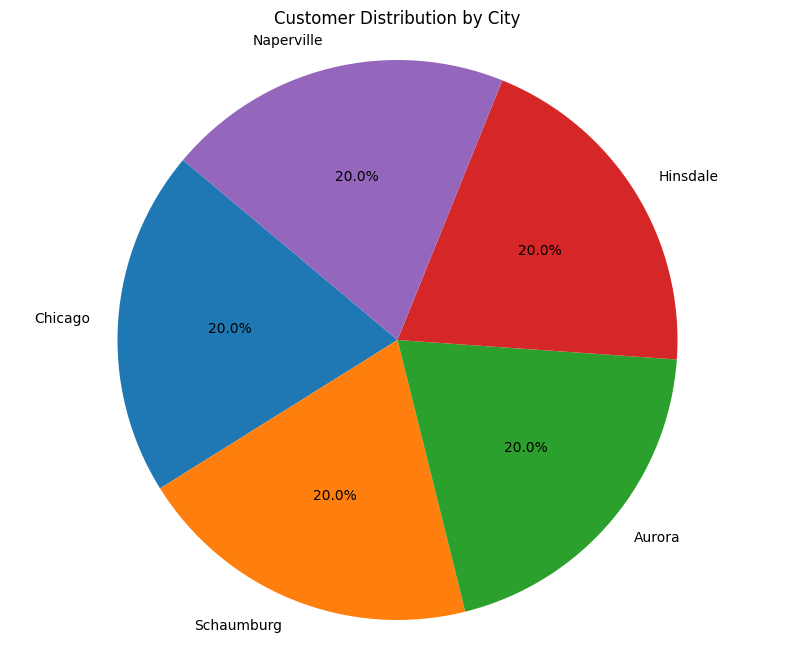

In [73]:
import matplotlib.pyplot as plt

customer_data_sdf = spark.read.format("bigquery").option("table", "rscw_iceberg_curated_ds.customer_master").load()
customer_data_pdf = customer_data_sdf.toPandas()

city_counts = customer_data_pdf['city'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Distribution by City')
plt.axis('equal')
plt.show()

## This concludes the module, proceed to the user manual for the next module that delves into BigLake Iceberg REST catalog and more